<a id='Index'></a>

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center"> Index </h1></span>

Section List

<a href='#Import-Libraries'> 1. Import Libraries + Settings</a>

<a href='#Load-Data'> 2. Load Data </a>

<a href='#Process-Data'> 3. EDA and Processing Data</a>

<a href='#Split-Data'> 4. Splitting Data into Training and Testing Sets </a>



<a id='Import-Libraries'></a>
# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center"> Import Libraries </h1></span>
<a href='#Index'> Back to Index</a>

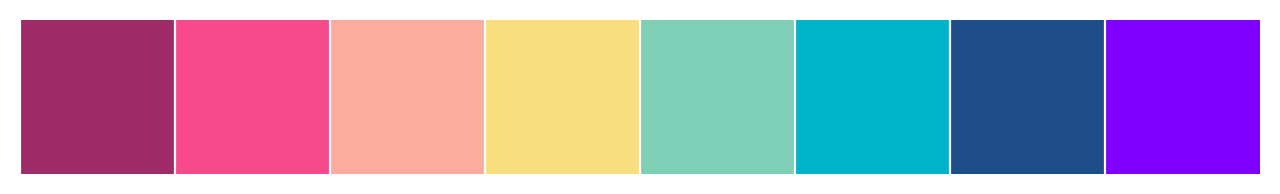

In [10]:
# read raw input
import json

# dataframe manipulation
import pandas as pd 
import numpy as np
import re

# text feature extraction
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from collections import defaultdict
import datetime

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# other stuff
import random
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

np.random.seed(888) # set seed to split data into training and testing later.

# set stype
plt.style.use("seaborn-darkgrid")
%config InlineBackend.figure_format = 'retina'
my_palette = ['#9F2B68', '#f64a8a', '#fdab9f', '#F8DE7E', '#7dcfb6', '#00b2ca', '#1d4e89', '#7F00FF'] 
sns.set_palette(palette=my_palette)
sns.palplot(sns.color_palette(my_palette))

<a id='Load-Data'></a>
# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center"> Loading Data </h1></span>
<a href='#Index'> Back to Index</a>

In [11]:
### Loaad data and make a Dataframe before making 
DATA_PATH = 'datasets/rental_listing.json'

with open(DATA_PATH) as f:
    train_df = json.load(f)

train_df = pd.DataFrame.from_dict(train_df)
print(train_df.shape)
train_df.head(3)

(49352, 15)


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium


<a id='Process-Data'></a>
# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center"> EDA and Processing Data </h1></span>
<a href='#Index'> Back to Index</a>

Note:

_For this assignment, as the dataset include links to photos of rental listings and also descriptions written by the original posters. For the sake of simplicity and that the main focus of this assignment is on the analysis of algorithms, we would simply convert description into number of words used. For photos, we'd simply use the number of photos instead. Other columns not used for this dataset include 'display_address', 'street_address'. 

_ Also there is one listing (id 7122037) where the price listed is different from the price mentioned in the description, we will use the price from the description instead.

_ We'd also mapping interest levels: {'low':0, 'medium':1, 'high':2} as the labels we want to predict

# Processing steps:
_ drop 'listing_id'

_ Making new features: 

    + 'photos_num': count number of photos
    + 'description_len': number of words used in 'description'
    + New dummy predictors from "features": Manual processing of rental features from column 'features' (doorman, laundry in building, etc ...) by selecting the top most frequently occurred keywords
    + 'created_delta': Convert created date into timedelta with respect to the day the competition started (Feb 9, 2017)
    + 'building_rental_count' : the "building_rental_count" is how many units share the same building id. Note that there are 8286 cases where building id is 0, the rest is a string.
    + 'manager_rental_count': how many units share the same manager id
_ All processing steps are applied to the full data.

_ No predictor-target analysis is conducted on the dataset to ensure that testing dataset is "hidden"


### Processing 'features' column: 

_ make a new predictor column to count the number of strings for each instance/sample in the 'features' column.

_ create a counter dictionary to determine the 20 most commonly occured strings. Then encode each of these 20 as a dummy binary predictor.

In [12]:
def split_remove(s:str) -> list:
    """
    function to process words in a description. First change '-' to '_' to preserve some compound words such as 3-bedroom. Then remove all non-alphanumeric characters except for underscore.

    Args:
        s (str): input string

    Returns:
        list: list of words from processed input string
    """
    non_rm = '_'
    s = re.sub(r"[^\w'+non_rm+']", ' ',s.replace('\r','').replace('-', '_'))
    s = [i for i in s.split() if i != '']
    return s

def make_feature_count(df: pd.DataFrame) -> list[tuple]:
    """
    funtion to generate a dictionary to count the number of occurrence for items described in rental listing features.

    Args:
        df (pd.DataFrame): input dataframe

    Returns:
        list[tuple]: list of tuples, each tuple is the feature item and its count
    """
    count_dict = defaultdict(int)
    feats = [j for i in df['features'].values for j in i]
    for f in feats:
        count_dict[f] += 1
    count_dict = sorted(count_dict.items(), key = lambda x: x[1], reverse=True)
    return count_dict

def make_dummy_predictor(df: pd.DataFrame, vars: list[str]) -> pd.DataFrame:
    """
    function to encode new predictors/variables for input dataframe based on the given list of variables.

    Args:
        df (pd.DataFrame): input dataframe
        vars (list[str]): list of strings, each string is a new variable/predictor/column

    Returns:
        pd.DataFrame: _description_
    """
    for v in vars:
        df[v] = df['features'].apply(lambda x: 1 if v in x else 0)
    return df

def make_id_predictor(df: pd.DataFrame, id_dict: dict) -> pd.DataFrame:
    """
    function to create new predictors/variables for input dataframe based on the given_id dictionary

    Args:
        df (pd.DataFrame): _description_
        id_dict (dict): dictionary where the first key-value pair is the name of column used for counting (e.g. building_id or manager_id), the rest of the key-value pairs are for mapping between id and count

    Returns:
        pd.DataFrame: _description_
    """
    col_name = id_dict.pop('column_name')
    train_df[col_name+'_ct'] = train_df[col_name].map(id_dict)
    return train_df


In [13]:
# drop columns 'display_address' and 'street_address'
train_df.loc[train_df.listing_id == 7122037, 'price'] = 1025

# Conver the photo links to number of photos
train_df['photos_num'] = train_df['photos'].apply(len)

# Convert 'description' to number of words used in description
train_df['description_len'] = train_df['description'].apply(lambda x: len(split_remove(x)))

# feature_len
train_df['features_len'] = train_df['features'].apply(len)

# make new dummy predictors
features_count = make_feature_count(train_df)
top_feats = [i[0] for i in features_count[:20]]
train_df = make_dummy_predictor(train_df, top_feats)

# make studio predictor
train_df['studio'] = train_df['bedrooms'].map(lambda x: 1 if x == 0 else 1)

# # make price_bedroom_ratio and price_bedbath_ratio
# train_df['price_bed_ratio'] = train_df['price'] / train_df['bedrooms']
# train_df['price_bedbath_ratio'] = train_df['price'] / (train_df['bedrooms'] + train_df['bathrooms'])

# convert 'created' date to unix time stamp w.r.t to competition start date
comp_time = comp_time = '2017/02/09'
train_df['created_delta'] = (pd.to_datetime(train_df['created']) - datetime.datetime.strptime(comp_time, '%Y/%m/%d')).astype('int')/10e9

# drop column 'description', 'display_address', 'street_address', 'photos', 'created', and 'listing_id'
train_df.drop(columns=['description', 'display_address', 'street_address', 'photos', 'created', 'listing_id'], inplace=True)

Number of unique building ids:  7585


0                                   8286
96274288c84ddd7d5c5d8e425ee75027     275
11e1dec9d14b1a9e528386a2504b3afc     215
80a120d6bc3aba97f40fee8c2204524b     213
bb8658a3e432fb62a440615333376345     212
                                    ... 
942a26f70feab981adc10ea719db9813       1
38c291a212567bd5a5937278b0c871aa       1
80b6723e1002c54dfd28d8c8cff69a61       1
f499cb726ebde29a2a6082ea061f65a7       1
e125ca74a8353517f1c9dcc43fed068b       1
Name: building_id, Length: 7585, dtype: int64

Number of building ids with only 1 listing: 3659
Number of building ids with fewer than 10 listings: 6714


Text(0.5, 1.0, 'Scatter plot of descending value count for building ids')

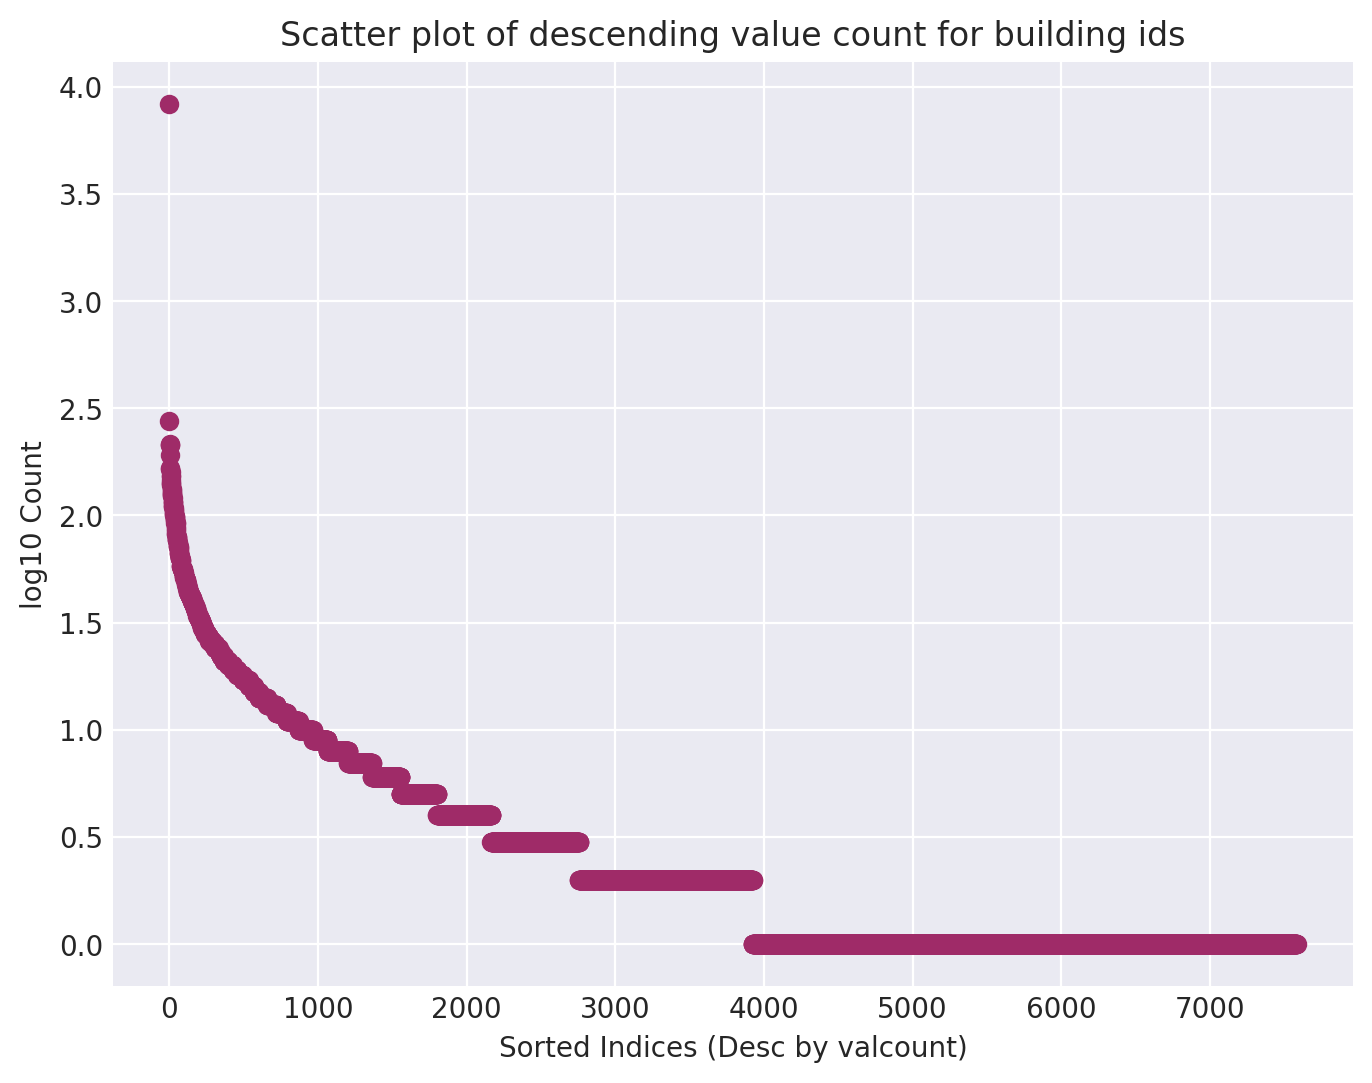

In [14]:
# for building ids, there are 8286 cases where ids are 0
valcount_building_id = train_df['building_id'].value_counts()
print(f'Number of unique building ids: ', len(valcount_building_id))
display(valcount_building_id)
print(f'Number of building ids with only 1 listing: {len(valcount_building_id[valcount_building_id.values == 1])}')
print(f'Number of building ids with fewer than 10 listings: {len(valcount_building_id[valcount_building_id.values <= 10])}')
# apply log10 to value counts
log10_valcount = np.log10(valcount_building_id.values)
# plot the log10 value counts
plt.figure(figsize=(8,6))
plt.scatter(x=range(len(log10_valcount)), y=log10_valcount)
plt.ylabel("log10 Count")
plt.xlabel("Sorted Indices (Desc by valcount)")
plt.title("Scatter plot of descending value count for building ids")

In [15]:
# make building_id_count
building_id_dct = valcount_building_id.to_dict()
building_id_dct['column_name'] = 'building_id'
train_df = make_id_predictor(train_df, building_id_dct)

# make manager_id_count 
manager_id_dct = train_df['manager_id'].value_counts().to_dict()
manager_id_dct['column_name'] = 'manager_id'
train_df = make_id_predictor(train_df, manager_id_dct)

# drop building_id and manager_id and features
train_df = train_df.drop(columns=['building_id', 'manager_id', 'features'])
print(f'Final features list {train_df.columns}')
train_df.head()

Final features list Index(['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price',
       'interest_level', 'photos_num', 'description_len', 'features_len',
       'Elevator', 'Cats Allowed', 'Hardwood Floors', 'Dogs Allowed',
       'Doorman', 'Dishwasher', 'No Fee', 'Laundry in Building',
       'Fitness Center', 'Pre-War', 'Laundry in Unit', 'Roof Deck',
       'Outdoor Space', 'Dining Room', 'High Speed Internet', 'Balcony',
       'Swimming Pool', 'Laundry In Building', 'New Construction', 'Terrace',
       'studio', 'created_delta', 'building_id_ct', 'manager_id_ct'],
      dtype='object')


,bathrooms,bedrooms,latitude,longitude,price,interest_level,photos_num,description_len,features_len,Elevator,...,High Speed Internet,Balcony,Swimming Pool,Laundry In Building,New Construction,Terrace,studio,created_delta,building_id_ct,manager_id_ct
4,1.0,1,40.7108,-73.9539,2400,medium,12,81,7,0,...,0,0,0,0,0,0,1,-2054187.3,5,112
6,1.0,2,40.7513,-73.9722,3800,low,6,136,6,1,...,0,0,0,0,0,0,1,-2183852.7,51,26
9,1.0,2,40.7575,-73.9625,3495,medium,6,124,6,1,...,0,0,0,0,0,0,1,-2068080.1,71,93
10,1.5,3,40.7145,-73.9425,3000,medium,5,99,0,0,...,0,0,0,0,0,0,1,-1984353.6,3,90
15,1.0,0,40.7439,-73.9743,2795,low,4,46,4,1,...,0,0,0,0,0,0,1,-1951257.7,86,55


<a id='Split-Data'></a>
# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center"> Splitting Data into Training and Testing Datasets </h1></span>
<a href='#Index'> Back to Index</a>

In [16]:
# map interest levels and move this column to last
train_df['interest_level'] = train_df['interest_level'].replace({'low':0, 'medium': 1, 'high':2})
train_df = train_df[[col for col in train_df.columns if col != 'interest_level'] + ['interest_level']]

# splitting data into training and (hidden) test sets. There are 49352 so we arbitrarily use 9352 for testing
test_idx = np.random.choice(range(train_df.shape[0]), size=9352, replace=False)
test_df = train_df.iloc[test_idx]
train_df = train_df.iloc[~test_idx]
print(f'train_df shape {train_df.shape}, test_df.shape {test_df.shape}')
display(train_df.head())

train_df shape (9352, 33), test_df.shape (9352, 33)


,bathrooms,bedrooms,latitude,longitude,price,photos_num,description_len,features_len,Elevator,Cats Allowed,...,Balcony,Swimming Pool,Laundry In Building,New Construction,Terrace,studio,created_delta,building_id_ct,manager_id_ct,interest_level
107960,1.0,0,40.7419,-73.9776,2195,3,80,5,1,0,...,0,0,0,0,0,1,-2667333.1,5,60,2
105095,1.0,1,40.7708,-73.9576,2500,6,65,2,0,0,...,0,0,0,0,0,1,-2633738.8,7,154,0
74885,1.0,2,40.7545,-73.9984,3100,5,123,5,1,0,...,0,0,0,0,0,1,-2340253.5,55,57,0
107767,1.0,3,40.7556,-73.9922,3995,6,206,8,1,1,...,0,0,0,0,0,1,-2642277.4,62,2533,1
20975,1.0,2,40.7681,-73.9544,2700,6,65,2,0,0,...,0,0,0,0,0,1,-2184417.0,37,73,1


In [17]:
train_df['interest_level'].value_counts()

0    6528
1    2136
2     688
Name: interest_level, dtype: int64

# Try DT

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier as DTC

X_train = train_df.loc[:, train_df.columns != 'interest_level']
y_train = train_df['interest_level'].map({'low':0, 'medium': 1, 'high':2})


clf = DTC()
clf.fit(X_train, y_train)

# Try NN

In [ ]:
%%time

from sklearn.neural_network import MLPClassifier

X_train = train_df.loc[:, train_df.columns != 'interest_level']
y_train = train_df['interest_level'].map({'low':0, 'medium': 1, 'high':2})

clf = MLPClassifier(random_state=88, max_iter=50).fit(X_train, y_train)

# Try boosting

In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

X_train = train_df.loc[:, train_df.columns != 'interest_level']
y_train = train_df['interest_level'].map({'low':0, 'medium': 1, 'high':2})

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)

# Try SVM

In [ ]:
%%time
from sklearn.svm import SVC

X_train = train_df.loc[:, train_df.columns != 'interest_level']
y_train = train_df['interest_level'].map({'low':0, 'medium': 1, 'high':2})

clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

# Try KNN

In [ ]:
%%time
>>> from sklearn.neighbors import KNeighborsClassifier

X_train = train_df.loc[:, train_df.columns != 'interest_level']
y_train = train_df['interest_level'].map({'low':0, 'medium': 1, 'high':2})

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)